In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## GW catalogue & SNR

In [2]:
gwtc=pd.read_csv('/home/miguel/code/notebooks/gw_data/GWTC.csv')

In [17]:
# print(gwtc)

(array([ 3., 15., 16., 18., 11., 10.,  4.,  3.,  4.,  1.,  3.,  0.,  0.,
         0.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([ 6.  ,  7.35,  8.7 , 10.05, 11.4 , 12.75, 14.1 , 15.45, 16.8 ,
        18.15, 19.5 , 20.85, 22.2 , 23.55, 24.9 , 26.25, 27.6 , 28.95,
        30.3 , 31.65, 33.  ]),
 <BarContainer object of 20 artists>)

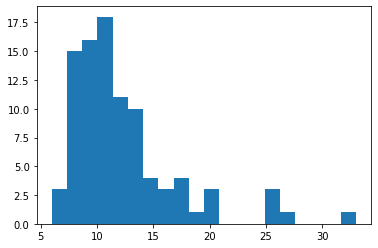

In [7]:
#look at the SNR distribution
plt.hist(gwtc['network_matched_filter_snr'],20)

## Import $\Upsilon_{\rm obs}(\beta_{\rm min},\mu_{\rm min})$

In [16]:
#Load the data (computed in )
data_dict = np.load("../data/Ups_obs_mu_min.npy", allow_pickle=True).item()
betalims = data_dict["betalims"]
mu_min_arr = data_dict["mu_min_arr"]
ups_obs_arr = data_dict["ups_obs_arr"]

<ipython-input-20-8506243ae775>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


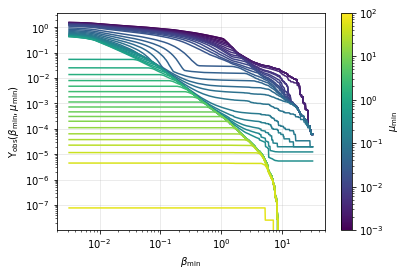

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

ups_obs_arr = np.array(ups_obs_arr)


fig, ax = plt.subplots()
lines = []

mu_min_norm = colors.LogNorm(vmin=min(mu_min_arr), vmax=max(mu_min_arr))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=mu_min_norm, cmap='viridis'), ax=ax)
cmap = plt.cm.get_cmap('viridis')

for i, mu_min in enumerate(mu_min_arr):
    line, = ax.loglog(betalims, ups_obs_arr[i, :], c=cmap(mu_min_norm(mu_min)))
    lines.append(line)

cbar.set_label(r'$\mu_{\rm min}$')



ax.set_ylabel(r"$\Upsilon_{\rm obs}(\beta_{\rm min},\mu_{\rm min})$")
ax.set_xlabel(r"$\beta_{\rm min}$")

ax.grid(alpha=0.3)
plt.show()

fig.tight_layout()
# if tosave:
#     fig.savefig(join(fout, "ups_obs_magnif_many.pdf"), dpi=450)

Generalizing the previous expression we have the following detection probability

$$p_i = f(M,r_{\rm src}) \int d\mu \mu^{3/2} \frac{d\Upsilon_{\rm Obs}}{d\mu}(\beta^i_{\rm ex}(M),r_{\rm src},\mu) = \frac{3}{2}f(M,r_{\rm src}) \int d\mu \mu^{1/2} \Upsilon_{\rm Obs}(\beta^i_{\rm ex}(M),r_{\rm src},\mu)$$

Notes:
* $\mu^{3/2}$ is a volume prior: very demagnified events are detectable, but they'd have to be very close to us (at observed SNR)
* the second expression follows by partial integration, so we can work with $\Upsilon_{\rm Obs}$
* we're allowing for arbitrary many loops (this can be reduced)
* we're considering the images individually

Going forward:
* figure out scaling with $r_{\rm src}$
* given $r_{\rm src},M$, interpolate on $\beta(M), r_{\rm src}$ for all the available $\mu$'s. Then do the magnification integral through array

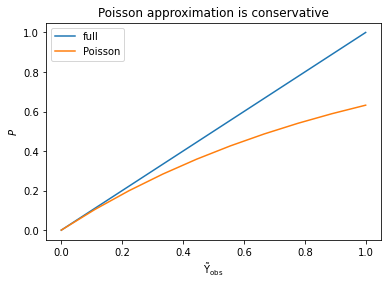

In [30]:
x = np.linspace(0,1,10)
plt.plot(x,x,label='full')
plt.plot(x,1-np.exp(-x),label='Poisson')
plt.title('Poisson approximation is conservative')
plt.xlabel(r'$\tilde \Upsilon_{\rm obs}$')
plt.ylabel(r'$P$')
plt.legend()

## Mismatch

We will use a simple criterion for detectability when $\mathcal{M}\cdot {\rm SNR}^2>1$ to estimate the number of detectable signals.

If we use our scaling as $\beta^2$ (for small $\beta$) then we can obtain the limit $\beta< \frac{\beta_0}{ \sqrt{\mathcal{M_0}} {\rm SNR}}$

In [99]:
from pycbc.filter.matchedfilter import match, sigmasq, optimized_match
from pycbc.filter import matched_filter
import pycbc as pycbc 
from astropy.cosmology import Planck18 as cosmo
import sys, os

from pycbc.waveform import get_fd_waveform

# sys.path.insert(0, os.path.abspath('../../glow/lensing_code/'))
# from mismatch_tools import mismatch

# sys.path.insert(0, os.path.abspath('../../diffinteg_gnfw/'))
# from fisher import waveform



In [60]:

def waveform(mass, z = 3, q=1, spin =0, inc = 1,
             t_obs = 10,n_sample=300,f_max_wrt_isco=1,
             detector_frame_mass=True):

    if detector_frame_mass: #then redshift to the actual mass
        mass = mass*(1+z)
    DL = cosmo.luminosity_distance(z).to('Mpc').value #it's given in Mpc but just in case


    fmin = f0_obs(mass,t_obs,eta=1/(1+q)**2) #NOTE: argument was t_obs/2.
    fmax = f_max_wrt_isco*f_isco(mass)
#     df = (fmax-fmin)/1000
    df = fmin*0.1


    #min freq is 10y before coallescence

    hp, hx = get_fd_waveform(approximant = 'IMRPhenomD',
                            mass1 = mass * q/(1. + q),
                            mass2 = mass * 1/(1. + q),
                            spin1z = spin,
                            spin2z = spin,
                            distance = DL,
                            inclination = inc,
                            long_asc_nodes = 0,
                            f_lower=fmin,
                            f_final = fmax,
                            delta_f = df)

    sample_freqs = hp.sample_frequencies
    # trim the nonzero values
    nonzeros = np.nonzero(hp)
    if len(nonzeros[0]) > 1:
        front = nonzeros[0][0]
        back = nonzeros[0][-1]
        freqs = np.logspace(np.log10(sample_freqs[front]),np.log10(sample_freqs[back]),n_sample)
    else:
        freqs = np.logspace(np.log10(sample_freqs[0]),np.log10(sample_freqs[-1]),n_sample)

    return freqs, hp,hx


def f_isco(M_tot): #TODO ADD, xi, cf eq 16 of https://arxiv.org/pdf/1608.01940.pdf
    '''GW frequency (2x orbital freq) of innermost stable circular orbit
       M_tot = total mass in solar masses
       f_isco in Hz
    '''

    return 2.*2198.8/M_tot
#     return 1./(6.*np.sqrt(6.)*np.pi*M_tot*2.95/3e5)

def f0_obs(M,t_obs,eta=0.25,units='y'):
    #TODO: add reference or explanation
    '''initial GW frequency for a given observation time
       solving from Maggiore's book eq. 16.26
       NOTE: not including the redshift factor
       ft_obs -> observation time
       M -> total mass, M_sun
       eta -> reduced mass ratio m1m2/(m1+m2)^2
       unit -> 'y' (default)
       result is in Hz
    '''

    if t_obs == np.infty:
        return 0
    if units=='s':
        t_obs=t_obs
    elif units=='y':
        t_obs =t_obs*3.154e+7
    else:
        print('units not understood')
    return 150.98/(eta*t_obs*M**(5/3.))**(3/8.)

def f0_obs_old(M,t_obs,eta=0.25):
    t_bar = 0.0205544 #in years, default

    return 1/M*(M*t_bar/t_obs/eta)**(3./8.)

def t_merge(M,f0,eta=0.25, unit = 'y'):
    '''time to for a binary to merge
       cf. Maggiore's book eq. 16.26
       NOTE: not including the redshift factor
       f0 -> initial frequency, Hz
       M -> total mass, M_sun (NOT CHIRP MASS!)
       eta -> reduced mass ratio m1m2/(m1+m2)^2
       unit -> 's' or 'y' (default)
       result is in years
    '''

    result = 3e5/eta*(1e5/M)**(5/3.)*(1e-3/f0)**(8/3.)
    if unit=='s':
        return result
    elif unit=='y':
        return result/3.154e7
    else:
        print('unit not cocded yet')

In [224]:
import pandas as pd
from scipy.interpolate import interp1d

psd_ligo_read=pd.read_csv("../../glow/lensing_code/notebooks/sensitivities/aplus.txt", sep=" ", header=None ,index_col=None)
psd_ligo_arr=np.transpose(psd_ligo_read.to_numpy(dtype=float))
psd2=interp1d(psd_ligo_arr[0],psd_ligo_arr[1],kind='linear', fill_value='extrapolate')

psd_et_read = pd.read_csv("../../glow/lensing_code/notebooks/sensitivities/et.txt", sep=" ", header=None ,index_col=None)
psd_et_arr=np.transpose(psd_et_read.to_numpy(dtype=float))
psd_et2=interp1d(psd_et_arr[0],psd_et_arr[1],kind='linear', fill_value='extrapolate')


def psd_ligo(f):
    '''Power spectral density from https://dcc.ligo.org/LIGO-T1500293/public'''
    return float(psd2(f)**2)

def psd_et(f):
    '''Power spectral density for ET'''
    return float(psd_et2(f)**2)

psd_ligo=np.vectorize(psd_ligo)
psd_et = np.vectorize(psd_et)

def mismatch_gshe(M_bbh, q=1,M_fid = 1e4,bt_fid = 1, zS_waveform=0.3,f_low=10, f_max_wrt_isco=10,n_sample=5,psd_fun = psd_ligo):
    '''compute the fiducial mismatch and SNR'''
    
    t_obs= 1/12/30/24/60/2
    
    fs, hx, hp = waveform(M_bbh, q=q, z=zS_waveform, t_obs=t_obs, f_max_wrt_isco=f_max_wrt_isco, n_sample=n_sample)

    fs = hx.sample_frequencies
    delta_f = fs[1]-fs[0]
    
    psd = pycbc.types.frequencyseries.FrequencySeries(psd_fun(fs), delta_f)
    snr0 = pycbc.filter.matched_filter(hp, hp, psd=psd, low_frequency_cutoff=f_low)
    
    f0_fid = bt_fid/(M_fid*1e-5) #in Hz

    F_gshe = np.exp(2*np.pi*1j*f0_fid/(fs))
    F_gshe[F_gshe==np.nan]=1

    h_gshe = pycbc.types.frequencyseries.FrequencySeries(F_gshe*hx, delta_f)

    mismatch_fid = 1-optimized_match(hx, h_gshe, psd = psd,low_frequency_cutoff=f_low)[0]
    
    return [mismatch_fid, np.abs(snr0)[0]]

mismatch_gshe(10)

/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)
/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:390: RuntimeWarning: invalid value encountered in divide
  return self._data.__rtruediv__(other)
/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:217: RuntimeWarning: invalid value encountered in exp
  ret = getattr(ufunc, method)(*inputs, **kwargs)


[0.14786896623603862, 7.586905708401893]

/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)
/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:390: RuntimeWarning: invalid value encountered in divide
  return self._data.__rtruediv__(other)
/home/miguel/.local/lib/python3.8/site-packages/pycbc/types/array.py:217: RuntimeWarning: invalid value encountered in exp
  ret = getattr(ufunc, method)(*inputs, **kwargs)


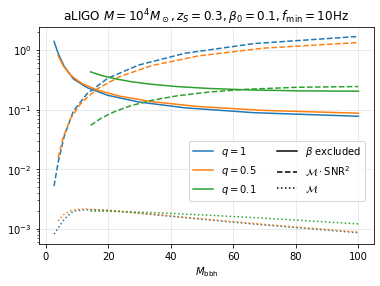

In [226]:
m_min = 1.3
bt_fid = 0.1
zS = 0.3
for i,q in enumerate([1,0.5,0.1]):
    Mbbh = np.geomspace(m_min*(1+1/q),100,10)
    dat = [mismatch_gshe(M,q=q,f_low=10,bt_fid=bt_fid,zS_waveform=zS,psd_fun=psd_ligo) for M in Mbbh]
    dat = np.array(dat)
    plt.semilogy(Mbbh,dat[:,0]*dat[:,1]**2,'--',c='C%i'%i)
    plt.plot(Mbbh,dat[:,0],':',c='C%i'%i)
    plt.plot(Mbbh,bt_fid/np.sqrt(dat[:,0])/dat[:,1],'-',label='$q=%g$'%q,c='C%i'%i)
    
plt.plot([],'k-',label=r'$\beta$ excluded')
plt.plot([],'k--',label=r'$\mathcal{M}\cdot{\rm SNR}^2$')
plt.plot([],'k:',label=r'$\mathcal{M}$')
    
plt.legend(ncol=2,loc=(0.45,0.2))
plt.xlabel(r"$M_{\rm bbh}$")
plt.title(r"aLIGO $M=10^4M_\odot, z_S=%g,\beta_0 =%g,f_{\rm min}=10$Hz"%(zS,bt_fid))
plt.grid(alpha=0.3)

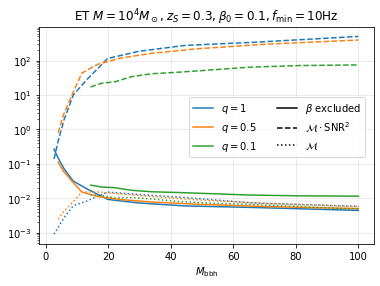

In [229]:
m_min = 1.3
bt_fid = 0.1
zS = 0.3
for i,q in enumerate([1,0.5,0.1]):
    Mbbh = np.geomspace(m_min*(1+1/q),100,10)
    dat = [mismatch_gshe(M,q=q,f_low=10,bt_fid=bt_fid,zS_waveform=zS,psd_fun=psd_et) for M in Mbbh]
    dat = np.array(dat)
    plt.semilogy(Mbbh,dat[:,0]*dat[:,1]**2,'--',c='C%i'%i)
    plt.plot(Mbbh,dat[:,0],':',c='C%i'%i)
    plt.plot(Mbbh,bt_fid/np.sqrt(dat[:,0])/dat[:,1],'-',label='$q=%g$'%q,c='C%i'%i)
    
plt.plot([],'k-',label=r'$\beta$ excluded')
plt.plot([],'k--',label=r'$\mathcal{M}\cdot{\rm SNR}^2$')
plt.plot([],'k:',label=r'$\mathcal{M}$')
    
plt.legend(ncol=2,loc=(0.45,0.4))
plt.xlabel(r"$M_{\rm bbh}$")
plt.title(r"ET $M=10^4M_\odot, z_S=%g,\beta_0 =%g,f_{\rm min}=10$Hz"%(zS,bt_fid))
plt.grid(alpha=0.3)

## Number of sources

Using https://github.com/hsinyuc/distancetool

Output--
Range (Mpc);
Redshift at which the detector can detect 50% of the uniformly distributed sources;
Redshift at which the detector can detect 10% of the uniformly distributed sources;
Redshift of the horizon;
Constant comoving time volume (Gpc^3);
Redshift within which 50% of the detected sources lie;
Redshift within which 90% of the detected sources lie;
Redshift within which 50% of the detected sources lie, the source distribution follows a star formation rate;
Redshift within which 90% of the detected sources lie, the source distribution follows a star formation rate;
Average redshift of the detected sources;
Average redshift of the detected sources, the source distribution follows a star formation rate.


In [241]:
import sys
sys.path.insert(0,'/home/miguel/code/utils/distancetool/codes/')

import find_horizon_range_de as gwhor

from importlib import reload

reload(gwhor)

<module 'find_horizon_range_de' from '/home/miguel/code/utils/distancetool/codes/find_horizon_range_de.py'>

In [244]:
out = gwhor.find_horizon_range(30,30,'/home/miguel/code/utils/distancetool/data/aLIGO/Advanced_LIGO_Design.txt')

9.0
SNR  8.007751030725208
1.2482958502122699


In [245]:
gw_range,zresp50,zresp90,horz,vol_sumGpc3,z50,z90,sfr_z50,sfr_z90,z_mean,sfr_z_mean = out

# (3.*vol_sum/4./pi)**(1./3.),z_response50,z_response90,horizon_redshift,vol_sum/1E9,z50,z90,sfr_z50,sfr_z90,z_mean,sfr_z_mean  

In [246]:
print(out)

(1643.9934507456817, 0.35576431731049696, 0.13107106427228832, 1.2482958502122699, 18.611820637074754, 0.42754132869770245, 0.758339729003954, 0.518042777838092, 0.8550826573954049, 0.4565038906027129, 0.5377020483519673)


In [248]:
print(z_mean)
print(vol_sumGpc3)

0.4565038906027129
18.611820637074754
